# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.8.3'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120711
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120711
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
264614,2020-09-26,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
264615,2020-09-27,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
264616,2020-09-28,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
264617,2020-09-29,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
264618,2020-09-30,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
264614,2020-09-26,Colombia,Vichada,14,0,0,14
264615,2020-09-27,Colombia,Vichada,14,0,0,14
264616,2020-09-28,Colombia,Vichada,14,0,0,14
264617,2020-09-29,Colombia,Vichada,14,0,0,14
264618,2020-09-30,Colombia,Vichada,14,0,0,14


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
191,2020-09-26,25113,2284,400,22429
192,2020-09-27,25257,2307,400,22550
193,2020-09-28,25335,2282,406,22647
194,2020-09-29,25547,2361,407,22779
195,2020-09-30,25741,2377,408,22956


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-09-26,32549288,9147652,989033,22412603,0.015193,0.344287,0.042263
2020-09-27,32790494,9180770,992496,22617228,0.015134,0.344875,0.042038
2020-09-28,33034548,9214808,996159,22823581,0.015078,0.345450,0.041821
2020-09-29,33306333,9267616,1001910,23036807,0.015041,0.345832,0.041679
2020-09-30,33307019,9267003,1001917,23038099,0.015041,0.345845,0.041677


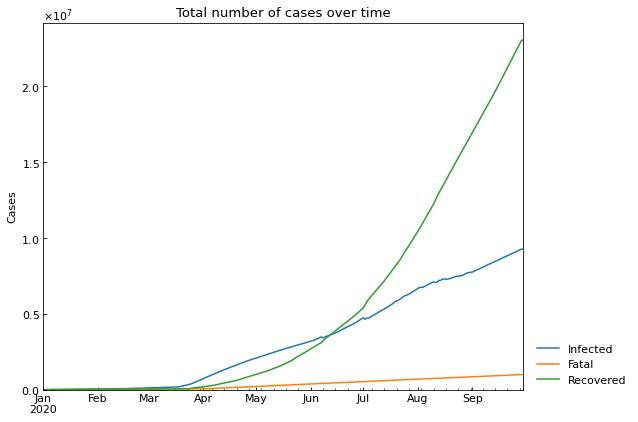

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
230,2020-09-26,81714,6036,1546,74132
231,2020-09-27,82199,6062,1549,74588
232,2020-09-28,82500,5970,1560,74970
233,2020-09-29,83032,6027,1567,75438
234,2020-09-30,83595,6023,1574,75998


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
228,2020-09-26,81055,5364,1540,74151
229,2020-09-27,81690,5538,1545,74607
230,2020-09-28,82131,5593,1548,74990
231,2020-09-29,82494,5478,1557,75459
232,2020-09-30,83010,5421,1564,76025


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
264614,2020-09-26,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
264615,2020-09-27,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
264616,2020-09-28,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
264617,2020-09-29,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
264618,2020-09-30,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
225427,COL,Colombia,Vichada,2020-09-26,107808
225428,COL,Colombia,Vichada,2020-09-27,107808
225429,COL,Colombia,Vichada,2020-09-28,107808
225430,COL,Colombia,Vichada,2020-09-29,107808
225431,COL,Colombia,Vichada,2020-09-30,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
264614,2020-09-26,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
264615,2020-09-27,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
264616,2020-09-28,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
264617,2020-09-29,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
264618,2020-09-30,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
264614,2020-09-26,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
264615,2020-09-27,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
264616,2020-09-28,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
264617,2020-09-29,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
264618,2020-09-30,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
269,2020-09-26,1,1,1,0,0,1,1,3,2,2,1,37.04
270,2020-09-27,1,1,1,0,0,1,1,3,2,2,1,37.04
271,2020-09-28,1,1,1,0,0,1,1,3,2,2,1,37.04
272,2020-09-29,1,1,1,0,0,1,1,3,2,2,1,37.04
273,2020-09-30,1,1,1,0,0,1,1,3,2,2,1,37.04


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
269,2020-09-26,1,1,1,0,0,1,1,3,2,2,1,37.04
270,2020-09-27,1,1,1,0,0,1,1,3,2,2,1,37.04
271,2020-09-28,1,1,1,0,0,1,1,3,2,2,1,37.04
272,2020-09-29,1,1,1,0,0,1,1,3,2,2,1,37.04
273,2020-09-30,1,1,1,0,0,1,1,3,2,2,1,37.04


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

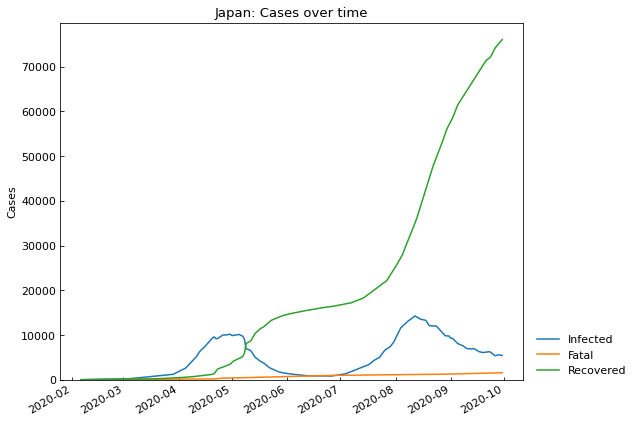

,Date,Confirmed,Infected,Fatal,Recovered
228,2020-09-26,81055,5364,1540,74151
229,2020-09-27,81690,5538,1545,74607
230,2020-09-28,82131,5593,1548,74990
231,2020-09-29,82494,5478,1557,75459
232,2020-09-30,83010,5421,1564,76025


In [26]:
import matplotlib
warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

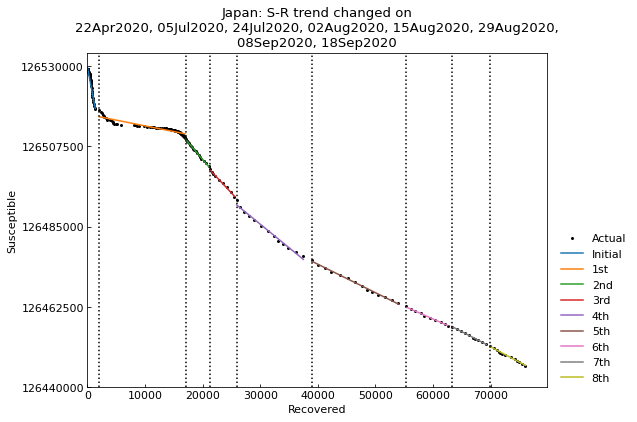

,Type,Start,End,Population
0th,Past,06Feb2020,21Apr2020,126529100
1st,Past,22Apr2020,04Jul2020,126529100
2nd,Past,05Jul2020,23Jul2020,126529100
3rd,Past,24Jul2020,01Aug2020,126529100
4th,Past,02Aug2020,14Aug2020,126529100
5th,Past,15Aug2020,28Aug2020,126529100
6th,Past,29Aug2020,07Sep2020,126529100
7th,Past,08Sep2020,17Sep2020,126529100
8th,Past,18Sep2020,30Sep2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>

Running optimization with 4 CPUs...

	8th phase (18Sep2020 - 30Sep2020): finished 1480 trials in 1 min  0 sec

	2nd phase (05Jul2020 - 23Jul2020): finished  167 trials in 0 min  5 sec

	3rd phase (24Jul2020 - 01Aug2020): finished 1045 trials in 0 min 40 sec

	0th phase (06Feb2020 - 21Apr2020): finished 1401 trials in 1 min  0 sec

	1st phase (22Apr2020 - 04Jul2020): finished 1399 trials in 1 min  0 sec

	5th phase (15Aug2020 - 28Aug2020): finished  720 trials in 0 min 25 sec

	4th phase (02Aug2020 - 14Aug2020): finished 1446 trials in 1 min  0 sec

	6th phase (29Aug2020 - 07Sep2020): finished  189 trials in 0 min  5 sec

	7th phase (08Sep2020 - 17Sep2020): finished  202 trials in 0 min  5 sec

Completed optimization. Total: 2 min  6 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/beta [day],1/gamma [day],alpha1 [-],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,21Apr2020,126529100,SIR-F,4.66,0.018341,0.000174,0.104200,0.021769,1440,9,45,0.018,5760,0.937856,1401,1 min 0 sec
1st,Past,22Apr2020,04Jul2020,126529100,SIR-F,0.39,0.080586,0.000941,0.029768,0.069508,1440,33,14,0.081,1062,0.883456,1399,1 min 0 sec
2nd,Past,05Jul2020,23Jul2020,126529100,SIR-F,1.88,0.000662,0.000069,0.142662,0.075667,1440,7,13,0.001,14505,0.043818,167,0 min 5 sec
3rd,Past,24Jul2020,01Aug2020,126529100,SIR-F,1.84,0.000726,0.000120,0.134241,0.072807,1440,7,13,0.001,8341,0.019265,1045,0 min 40 sec
4th,Past,02Aug2020,14Aug2020,126529100,SIR-F,1.56,0.000362,0.000408,0.102575,0.065443,1440,9,15,0.000,2450,0.062446,1446,1 min 0 sec
5th,Past,15Aug2020,28Aug2020,126529100,SIR-F,0.82,0.000562,0.000900,0.078347,0.094316,1440,12,10,0.001,1111,0.021244,720,0 min 25 sec
6th,Past,29Aug2020,07Sep2020,126529100,SIR-F,0.70,0.018778,0.000237,0.067977,0.094400,1440,14,10,0.019,4214,0.022170,189,0 min 5 sec
7th,Past,08Sep2020,17Sep2020,126529100,SIR-F,0.77,0.001663,0.001220,0.076790,0.098055,1440,13,10,0.002,819,0.019385,202,0 min 5 sec
8th,Past,18Sep2020,30Sep2020,126529100,SIR-F,0.89,0.000227,0.001169,0.081351,0.089863,1440,12,11,0.000,855,0.030135,1480,1 min 0 sec


### Accuracy of estimation

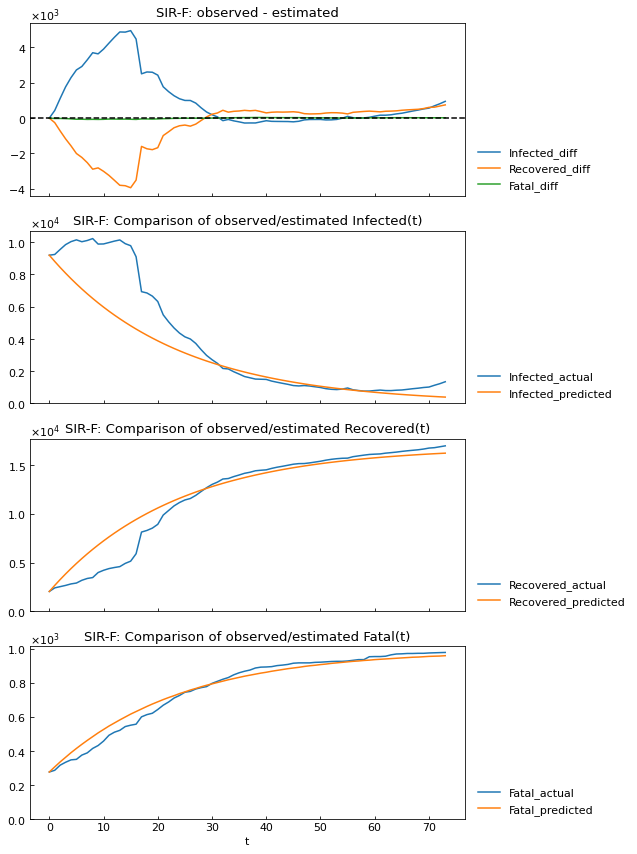

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

1.56

### Show parameter history

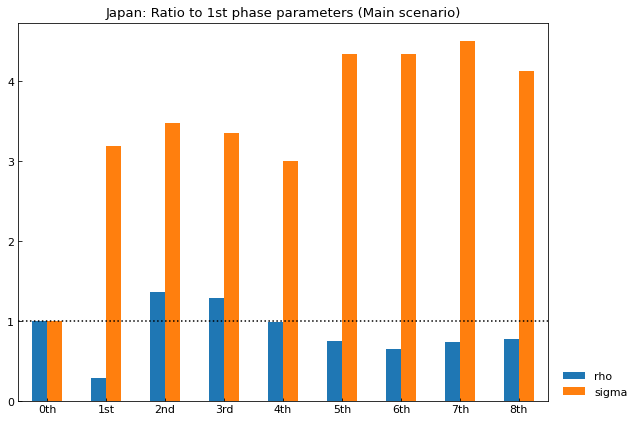

,0th,1st,2nd,3rd,4th,5th,6th,7th,8th
rho,1.0,0.285679,1.369116,1.288302,0.984407,0.751896,0.652373,0.736948,0.780721
sigma,1.0,3.193000,3.475959,3.344587,3.006264,4.332645,4.336512,4.504419,4.128081


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

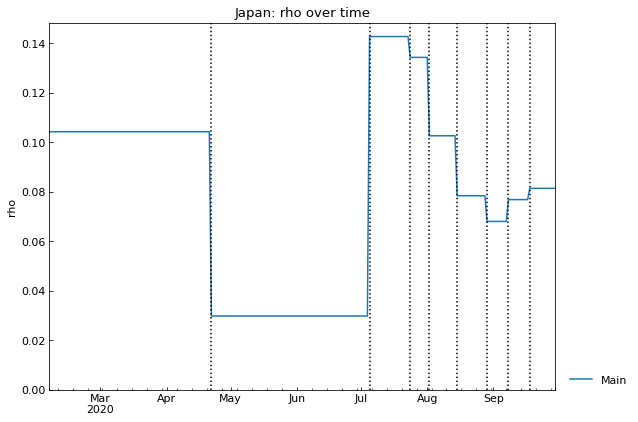

In [33]:
# version >= 2.8.0
_ = scenario.history(target="rho")

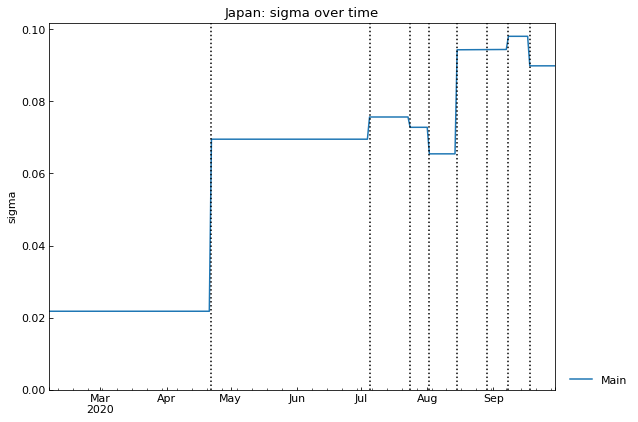

In [34]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

### Show the history of reproduction number

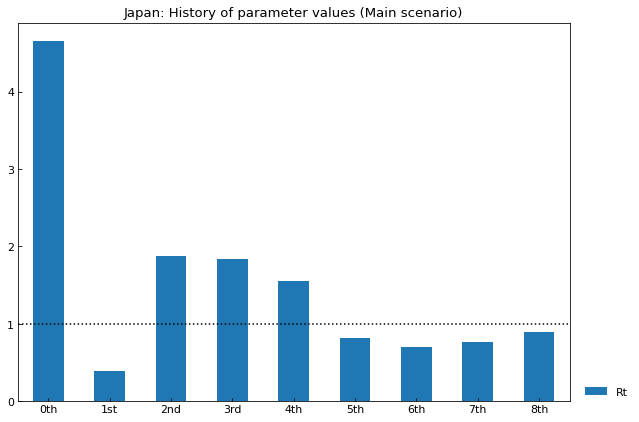

,0th,1st,2nd,3rd,4th,5th,6th,7th,8th
Rt,4.66,0.39,1.88,1.84,1.56,0.82,0.7,0.77,0.89


In [35]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

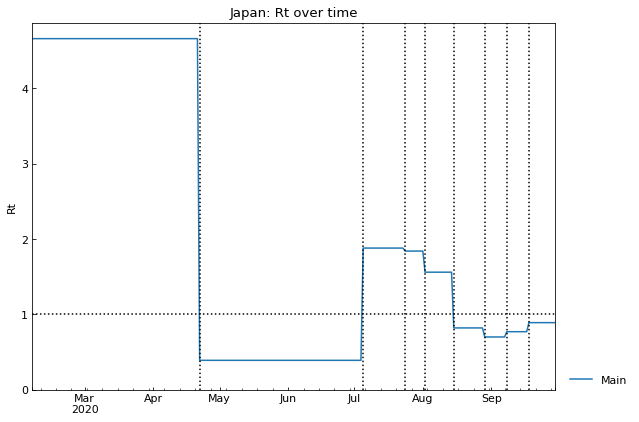

In [36]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

### Simulate the number of cases

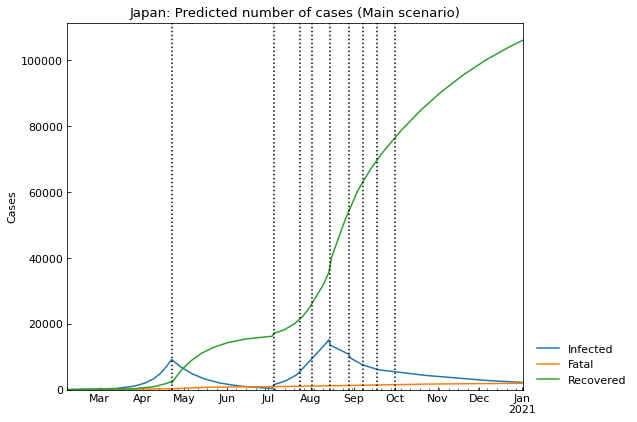

,Date,Confirmed,Fatal,Infected,Recovered
327,2020-12-29,109596,1951,2259,105386
328,2020-12-30,109779,1954,2237,105588
329,2020-12-31,109960,1957,2215,105788
330,2021-01-01,110138,1959,2193,105986
331,2021-01-02,110316,1962,2172,106182


In [37]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [38]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.08986303132504046

In [39]:
sigma_new = sigma_current * 2
sigma_new

0.17972606265008093

In [40]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.66   
         1st      Past  22Apr2020  04Jul2020   126529100  SIR-F  0.39   
         2nd      Past  05Jul2020  23Jul2020   126529100  SIR-F  1.88   
         3rd      Past  24Jul2020  01Aug2020   126529100  SIR-F  1.84   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.56   
         5th      Past  15Aug2020  28Aug2020   126529100  SIR-F  0.82   
         6th      Past  29Aug2020  07Sep2020   126529100  SIR-F  0.70   
         7th      Past  08Sep2020  17Sep2020   126529100  SIR-F  0.77   
         8th      Past  18Sep2020  30Sep2020   126529100  SIR-F  0.89   
         9th    Future  01Oct2020  01Jan2021   126529100  SIR-F  0.89   
Medicine 0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.66   
         1st      Past  22Apr2020  04Jul2020   126529100  SIR-F  0.39   
         2nd      Past  05Jul2020  23Jul2020   126529100  SIR-F  1.88   
         3rd      Past  24Jul2020  01Aug2020   126529100  SIR-F  1.84   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.56   
         5th      Past  15Aug2020  28Aug2020   126529100  SIR-F  0.82   
         6th      Past  29Aug2020  07Sep2020   126529100  SIR-F  0.70   
         7th      Past  08Sep2020  17Sep2020   126529100  SIR-F  0.77   
         8th      Past  18Sep2020  30Sep2020   126529100  SIR-F  0.89   
         9th    Future  01Oct2020  30Oct2020   126529100  SIR-F  0.89   
         10th   Future  31Oct2020  01Jan2021   126529100  SIR-F  0.45   

                   theta     kappa       rho     sigma   tau  1/beta [day]  \
Scenario Phase                                                               
Main     0th    0.018341  0.000174  0.104200  0.021769  1440             9   
         1st    0.080586  0.000941  0.029768  0.069508  1440            33   
         2nd    0.000662  0.000069  0.142662  0.075667  1440             7   
         3rd    0.000726  0.000120  0.134241  0.072807  1440             7   
         4th    0.000362  0.000408  0.102575  0.065443  1440             9   
         5th    0.000562  0.000900  0.078347  0.094316  1440            12   
         6th    0.018778  0.000237  0.067977  0.094400  1440            14   
         7th    0.001663  0.001220  0.076790  0.098055  1440            13   
         8th    0.000227  0.001169  0.081351  0.089863  1440            12   
         9th    0.000227  0.001169  0.081351  0.089863  1440            12   
Medicine 0th    0.018341  0.000174  0.104200  0.021769  1440             9   
         1st    0.080586  0.000941  0.029768  0.069508  1440            33   
         2nd    0.000662  0.000069  0.142662  0.075667  1440             7   
         3rd    0.000726  0.000120  0.134241  0.072807  1440             7   
         4th    0.000362  0.000408  0.102575  0.065443  1440             9   
         5th    0.000562  0.000900  0.078347  0.094316  1440            12   
         6th    0.018778  0.000237  0.067977  0.094400  1440            14   
         7th    0.001663  0.001220  0.076790  0.098055  1440            13   
         8th    0.000227  0.001169  0.081351  0.089863  1440            12   
         9th    0.000227  0.001169  0.081351  0.089863  1440            12   
         10th   0.000227  0.001169  0.081351  0.179726  1440            12   

                1/gamma [day]  alpha1 [-]  1/alpha2 [day]      RMSLE Trials  \
Scenario Phase                                                                
Main     0th               45       0.018            5760   0.937856   1401   
         1st               14       0.081            1062   0.883456   1399   
         2nd               13       0.001           14505  0.0438178    167   
         3rd               13       0.001            8341  0.0192649   1045   
         4th               15       0.000            2450  0.0624456 

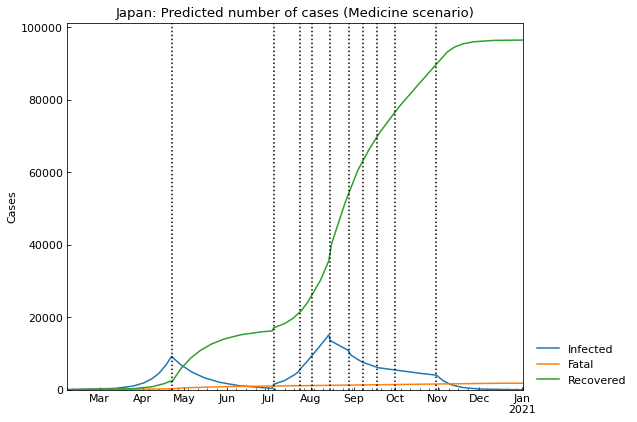

,Date,Confirmed,Fatal,Infected,Recovered
327,2020-12-29,98216,1785,11,96420
328,2020-12-30,98217,1785,10,96422
329,2020-12-31,98218,1785,9,96424
330,2021-01-01,98218,1785,8,96425
331,2021-01-02,98220,1785,8,96427


In [41]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [42]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 02Jan2021,Fatal on 02Jan2021,10th_Rt
Main,15170,14Aug2020,2172,1962,-
Medicine,15170,14Aug2020,8,1785,0.45


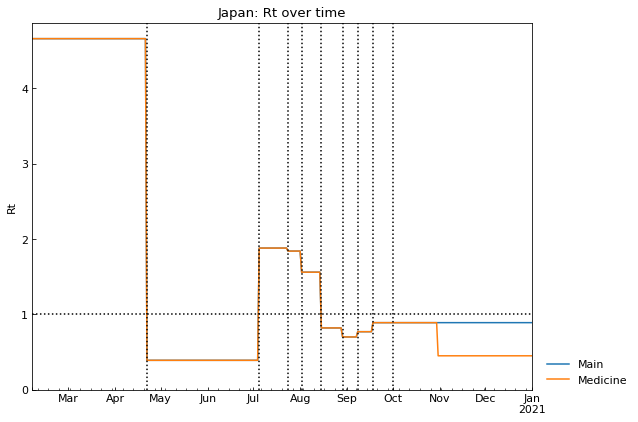

In [43]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

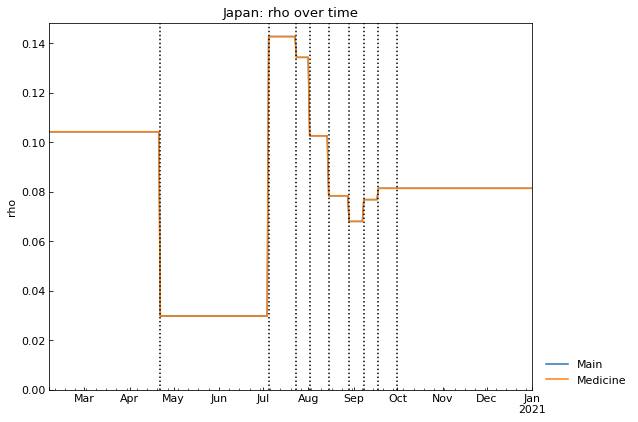

In [44]:
# version >= 2.8.0
_ = scenario.history(target="rho")

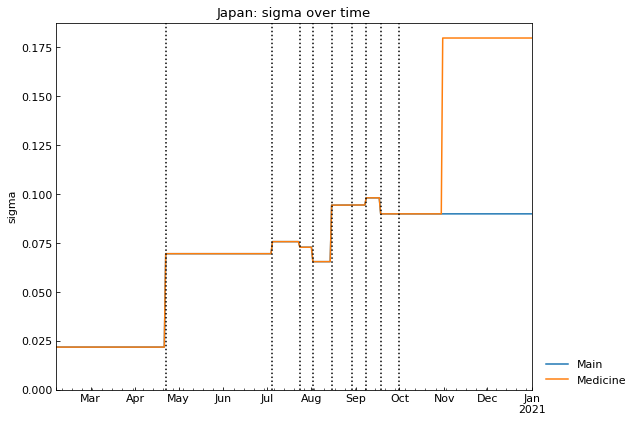

In [45]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

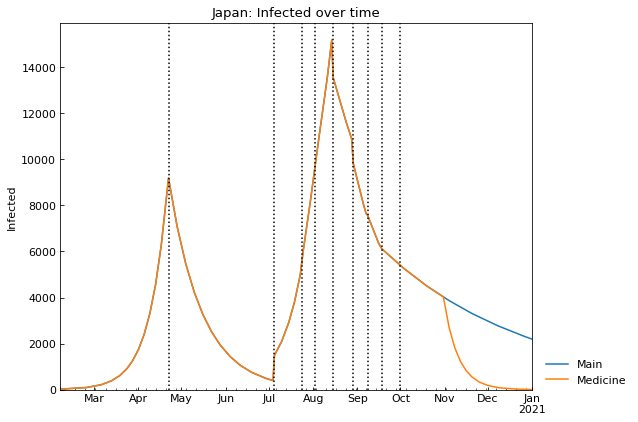

In [46]:
# version >= 2.8.0
_ = scenario.history(target="Infected")